In [1]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display
import matplotlib.patches as patches
import numpy as np


def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

In [2]:
madx = Madx(stdout=False)
madx.input('''
TITLE, ’CAS2019 Third  Exercise’; 

circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl={2.0*pi/(4*ncell)};

k_1_f:=0.0098*lq;
k_1_d:=-0.0098*lq;

!define quadrupoles as multipoles 
qf: multipole,knl:={0,k_1_f}; 
qd: multipole,knl:={0,k_1_d};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
cas: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
Beam, particle = proton, sequence=cas, energy = 20.0;

use, sequence=cas;

!!!!! very interesting option !!!!!
select,flag=interpolate, class=drift, slice=5, range=#s/#e;

ksf=0.005;
ksd=0.005;

twiss;
''')

True

In [3]:
def match_tunes_and_chromaticity(Qx, Qy):
    #match the tunes to Qx and Qy
    strMatch=f"""
        match, sequence=cas;
        global, q1={Qx};
        global, q2={Qy};
        global, dq1=0.;
        global, dq2=0.;
        vary,name=k_1_f, step=0.00001;
        vary,name=k_1_d, step=0.00001;
        vary,name=ksf, step=0.00001;
        vary,name=ksd, step=0.00001;    
        Lmdif, calls=5000, tolerance=1.0e-21;
        endmatch;
        twiss;
    """
    madx.input(strMatch)

In [4]:
match_tunes_and_chromaticity(2.5, 2.39)

In [5]:
def track_particles(nParticles, rmin, rmax):
    turns = 1000
    
    r = np.linspace(rmin, rmax, nParticles)
    theta = np.pi/6
    X = r*np.cos(theta)
    Y = r*np.sin(theta)
    madx.input(
        """
        TRACK, DUMP=TRUE, FILE=TRACKS;
        """
    )
    for i, xi in enumerate(X):
        yi = Y[i]
        madx.input(
            f"""
            START, X={xi}, Y={yi};
            """
        )
    for i in range(1):
        madx.input(
            """
            !OBSERVE, PLACE=ESEPTUM;
            RUN, TURNS={}, FFILE={};
            ENDTRACK;
            """.format(turns, 1)
        )

In [6]:
def calculate_DA(nParticles):
    for i in range(nParticles):
        table = np.loadtxt(f'tracks.obs0001.p'+str(i+1).zfill(4), skiprows=8,dtype=str)
        if (table[:,2]=='-nan(ind)').any():
            return float(table[0,2])

In [ ]:
nQx = 40
nQy = 40

rmin = 1e-6
rmax = 25

Qx_vec = np.linspace(2.01, 2.49, nQx)
#Qy_vec = np.array([2.3])
Qy_vec = np.linspace(2.01, 2.49, nQy)

DA_mat = np.zeros((nQx, nQy))

nParticles=25

for iQx, Qx in enumerate(Qx_vec):
    for iQy, Qy in enumerate(Qy_vec):
        print(f"Qx: {Qx}, Qy: {Qy}")
        #match the tunes to a certain value
        match_tunes_and_chromaticity(Qx, Qy)
        #track particles
        track_particles(nParticles, rmin, rmax)
        #calculate DA
        DA_mat[iQx, iQy] = calculate_DA(nParticles)
        

Qx: 2.01, Qy: 2.01
Qx: 2.01, Qy: 2.022307692307692
Qx: 2.01, Qy: 2.0346153846153845
Qx: 2.01, Qy: 2.046923076923077
Qx: 2.01, Qy: 2.059230769230769
Qx: 2.01, Qy: 2.0715384615384616
Qx: 2.01, Qy: 2.083846153846154
Qx: 2.01, Qy: 2.096153846153846
Qx: 2.01, Qy: 2.108461538461538
Qx: 2.01, Qy: 2.1207692307692305
Qx: 2.01, Qy: 2.133076923076923
Qx: 2.01, Qy: 2.1453846153846152
Qx: 2.01, Qy: 2.1576923076923076
Qx: 2.01, Qy: 2.17
Qx: 2.01, Qy: 2.1823076923076923
Qx: 2.01, Qy: 2.1946153846153846
Qx: 2.01, Qy: 2.206923076923077
Qx: 2.01, Qy: 2.2192307692307693
Qx: 2.01, Qy: 2.2315384615384617
Qx: 2.01, Qy: 2.243846153846154
Qx: 2.01, Qy: 2.256153846153846
Qx: 2.01, Qy: 2.2684615384615383
Qx: 2.01, Qy: 2.2807692307692307
Qx: 2.01, Qy: 2.293076923076923
Qx: 2.01, Qy: 2.3053846153846154
Qx: 2.01, Qy: 2.3176923076923077
Qx: 2.01, Qy: 2.33
Qx: 2.01, Qy: 2.3423076923076924
Qx: 2.01, Qy: 2.3546153846153848
Qx: 2.01, Qy: 2.366923076923077
Qx: 2.01, Qy: 2.3792307692307695
Qx: 2.01, Qy: 2.391538461538462

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(DA_mat, extent=[2.01,2.49,2.01,2.49])
#plt.imshow(DA_mat.T)
plt.colorbar(label='DA')
plt.xlabel('Qx')
plt.ylabel('Qy')
plt.title(f"nParticles={nParticles}, rmin={rmin}, rmax={rmax}")
print(nParticles)


plotTuneDiagram()
#plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'or');
newQ1=summAfterQCorrection.q1[0]
newQ2=summAfterQCorrection.q2[0]
#plt.plot(newQ1-np.floor(newQ1),newQ2-np.floor(newQ2),'og');

In [ ]:
# From R. Tomas
# http://cas.web.cern.ch/sites/cas.web.cern.ch/files/lectures/thessaloniki-2018/slidesbeamer.pdf
def Farey (n):
    '''Return the n-th Farey sequence, ascending.''' 
    seq = [[0 , 1]]
    a, b, c, d = 0, 1, 1, n
    while c <= n:
        k = int( (n + b)/d )
        a, b, c, d = c, d, k*c-a, k*d-b
        seq.append([a , b])
    return seq


def plotTuneDiagram():
    #fig=plt.figure(figsize=(5,5))
    #ax=plt.axes()
    plt.ylim((0,1))
    plt.xlim((0,1))
    x=np.linspace(0,1,1000)
    for i in range(1,6):
        FN=Farey(i) 
        for f in FN:
            h,k=f #Node h/k on the axes
            for sf in FN:
                p,q=sf
                c=float(p*h)
                a=float(k*p) #ResonancelineaQx+bQy=clinkedtop/q
                b=float(q-k*p)
                if a>0:
                    plt.plot(x,c/a-x*b/a,'r',alpha=.1)
                    plt.plot(x,c/a+x*b/a,'r',alpha=.1)
                    plt.plot(c/a-x*b/a,x,'r',alpha=.1)
                    plt.plot(c/a+x*b/a,x,'r',alpha=.1)
                    plt.plot(c/a-x*b/a,1-x,'r',alpha=.1)
                    plt.plot(c/a+x*b/a,1-x,'r',alpha=.1)
                if q==k and p==1: #FNelementsbelow1/k
                    break

    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('$Q_x$')
    plt.ylabel('$Q_y$');

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(DA_mat, extent=[0.01,0.49,0.01,0.49],alpha=0.75)
#plt.imshow(DA_mat.T)
plt.colorbar(label='DA')
plt.xlabel('Qx')
plt.ylabel('Qy')
plt.title(f"nParticles={nParticles}, rmin={rmin}, rmax={rmax}")
print(nParticles)


plotTuneDiagram()

plt.xlim(0,0.5)
plt.ylim(0,0.5)
#plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'or');
#newQ1=summAfterQCorrection.q1[0]
#newQ2=summAfterQCorrection.q2[0]
#plt.plot(newQ1-np.floor(newQ1),newQ2-np.floor(newQ2),'og');

In [ ]:
DA_mat

(-5.0, 150.0)

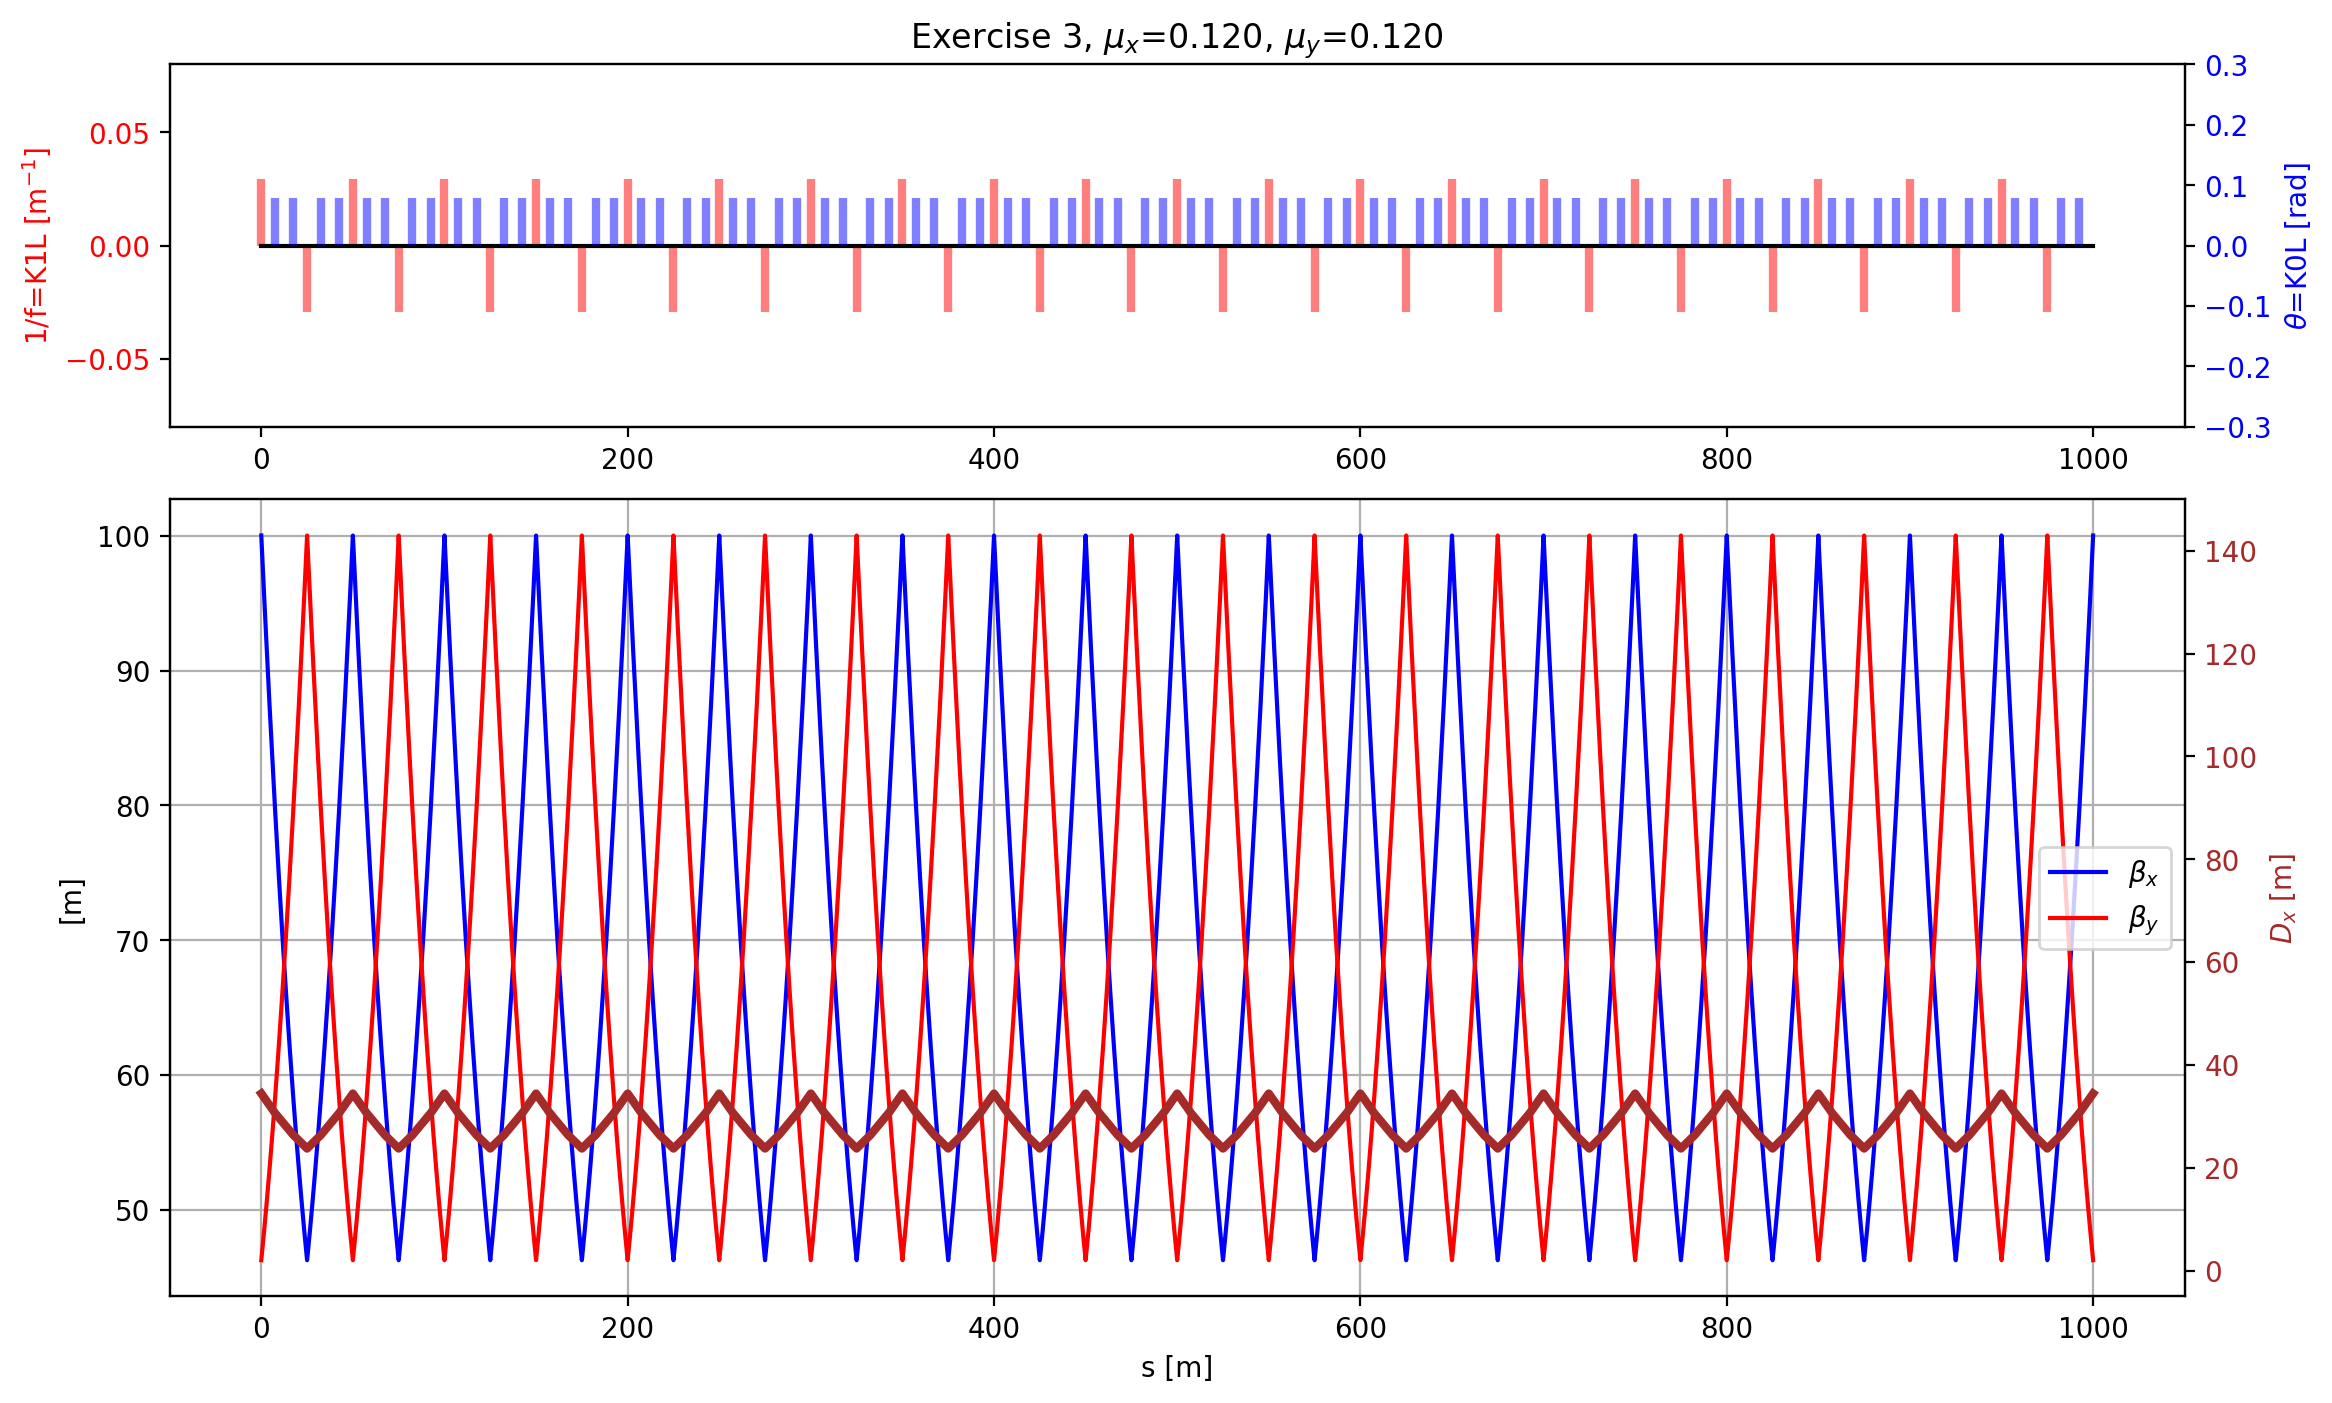

In [7]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 3, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)

In [11]:
nParticles = 10
turns = 1000

xmin = 1e-6
xmax = 1

X = np.linspace(xmin, xmax, nParticles)

In [12]:


print('-----------------------------------------------')
print('  Starting tracking for matched distribution')
print('  Turns: {}    Particles: {}'.format(turns,
                                            nParticles))
print()

madx.input(
    """
    TRACK, DUMP=TRUE, FILE=TRACKS;
    """
)
for xi in X:
    madx.input(
        f"""
        START, X={xi};
        """
    )
for i in range(1):
    madx.input(
        """
        !OBSERVE, PLACE=ESEPTUM;
        RUN, TURNS={}, FFILE={};
        ENDTRACK;
        """.format(turns, 1)
    )

-----------------------------------------------
  Starting tracking for matched distribution
  Turns: 1000    Particles: 10

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0              1e-06                  0 
         2          0           0.111112                  0 
         3          0           0.222223                  0 
         4

In [42]:
len(X)

10

In [19]:
nQx = 40
nQy = 40

rmin = 1e-6
rmax = 50

#Qx_vec = np.linspace(2.01, 2.49, nQx)
Qx_vec = np.array([2.33])
Qy_vec = np.array([2.33])
#Qy_vec = np.linspace(2.01, 2.49, nQy)

DA_mat = np.zeros((nQx, nQy))

nParticles=50

for iQx, Qx in enumerate(Qx_vec):
    for iQy, Qy in enumerate(Qy_vec):
        print(f"Qx: {Qx}, Qy: {Qy}")
        #match the tunes to a certain value
        match_tunes_and_chromaticity(Qx, Qy)
        #track particles
        track_particles(nParticles, rmin, rmax)
        #calculate DA
        DA_mat[iQx, iQy] = calculate_DA(nParticles)

Qx: 2.33, Qy: 2.33


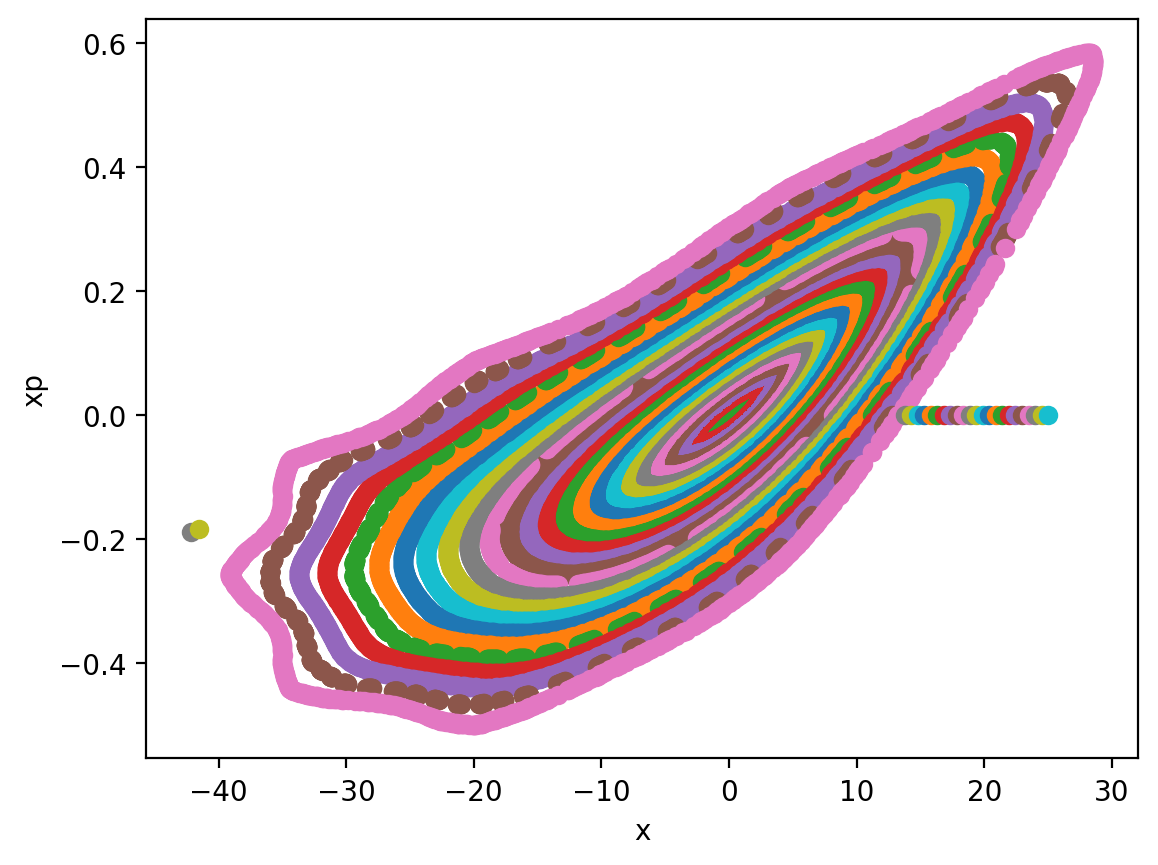

In [20]:
for i in range(nParticles):
    table = np.loadtxt(f'tracks.obs0001.p'+str(i+1).zfill(4), skiprows=8)
    plt.plot(table[:,2],table[:,3],'o')
    plt.xlabel('x')
    plt.ylabel('xp')    

In [17]:
Qy

2.49